In [1]:
#
#  Here I transform the raw data to prepare it for further analysis. I consider
#  only green and yellow cab data, as there is no tip information in the FHV data.
#  I consider only data from June 2017, as per the requirements of assigment.
#
#  In addition to basic cleansing of the data, I define a "standard" for comparing
#  tips _on a single trip level_ by normalizing tips by the taxi travel time. 
#

In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
# mpl.rcParams['figure.figsize'] = (10, 8)

In [6]:
data_location = 'yellow_tripdata_2017-06.csv'
yellow = pd.read_csv(
    data_location,
    parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']
)

data_location = 'green_tripdata_2017-06.csv'
green = pd.read_csv(
    data_location,
    parse_dates=['lpep_pickup_datetime', 'lpep_dropoff_datetime']
)
print(len(yellow))
print(len(green))

9656993
976467


In [7]:
#
#  0. I combine green cab and yellow cab data
#

# Add missing columns to yellow cab data
yellow['trip_type'] = np.nan
yellow['ehail_fee'] = np.nan

# Make sure I can separate data again
yellow['color'] = 'yellow'
green['color'] = 'green'

# Rename columns in green data
green = green.rename({
    'lpep_dropoff_datetime':'tpep_dropoff_datetime',
    'lpep_pickup_datetime':'tpep_pickup_datetime'}, axis='columns')
green = green[yellow.columns]

# Combine the data frames
yellow = pd.concat([yellow, green])
print(len(yellow))

10633460


In [8]:
#
#  1. I drop all trips not paid with credit cards.
#
#     Tips are not recorded for cash transactions. Dropping data from cash transactions
#     may significantly bias results if cash tips are distributed differently from credit
#     card tips. Let us assume, however, even if cash and credit card tips are distributed
#     differently, that their responses to geographic effects are correlated, so that
#     general trends seen in credit card data will match the (unseeable) trends in cash tips.
#
yellow = yellow[yellow.payment_type == 1]
del yellow['payment_type']
print(len(yellow))

7000127


In [9]:
#
#  2. I drop all rows with "impossible" data. 
#
#     According to http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml, for the
#     standard rate, the actual fare should be at least $2.50 * (1 + trip_distance^^). I assume
#     that all rows with fares less than this amount is corrupt data.
#
#         ^^ in miles, rounded down to nearest 1/5th of a mile
#

yellow = yellow[
    (yellow.RatecodeID != 1) ^ (
    (yellow.RatecodeID == 1) & \
    (yellow.fare_amount >= 2.5 + 0.5 * (5 * yellow.trip_distance).astype(int))
    )
]
print(len(yellow))

#
#    According to physics, distances between two distinct points should be positive.
#    I drop all trips with distances recorded as zero.
#
yellow = yellow[yellow.trip_distance > 0]
print(len(yellow))

#
#    According to physics, nothing travels faster than the speed of light. In addition to
#    the laws of physics, taxis must also obey traffic laws. Thus, I remove here all
#    trips that appear to happen too fast. Also, a car typically cannot drive longer than
#    several hours without refueling, so I remove excessively long trips too. The usual
#    caveats apply, but a casual inspection of these data points shows there is indeed
#    something weird (e.g. a 24-hour trip that went only a few miles and cost only $100).
#
#    These cut-off numbers are somewhat arbitrary, but they don't drop much data, seem 
#    plausible and really help clean up the target variable we construct in the next step.
#
yellow['trip_duration'] = abs(yellow.tpep_dropoff_datetime - yellow.tpep_pickup_datetime).dt.seconds / 60
yellow = yellow[60 * yellow.trip_distance / yellow.trip_duration < 75] # cut off at 75 mph mean speed
yellow = yellow[(yellow.trip_duration > 0.25) & (yellow.trip_duration < 240)]
print(len(yellow))

#
#     General comment:
#
#     It's possible that weird things in the data are in fact real, and that dropping data
#     here loses real data here along with the corrupt. However, the problem affects only
#     a small number of rows, and the effect of dropping a tiny amount of real data is
#     negligible compared to the effect of keeping a few horribly normalized training samples
#     (i.e. by dividing by zero) when I move on to regressions.
#

6996458
6966077
6949538


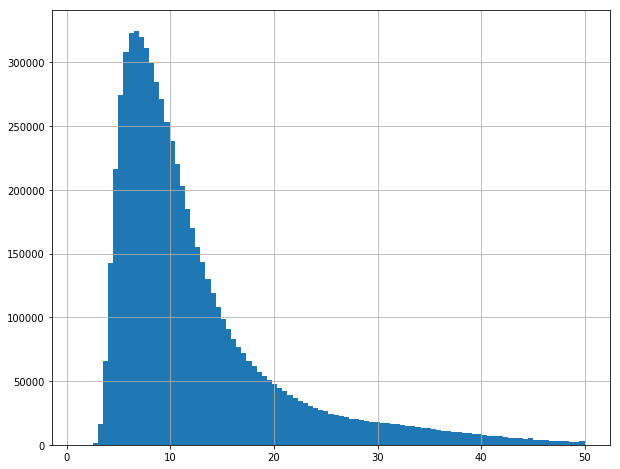

In [10]:
yellow.fare_amount.hist(bins=np.linspace(1, 50, 100))

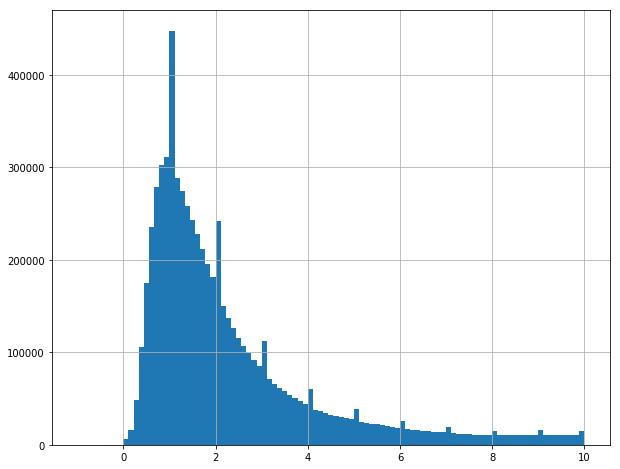

In [11]:
# strange to have peaks at integer distances, oder?
yellow.trip_distance.hist(bins=np.linspace(-1, 10, 100))

/home/privitera/education/env3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


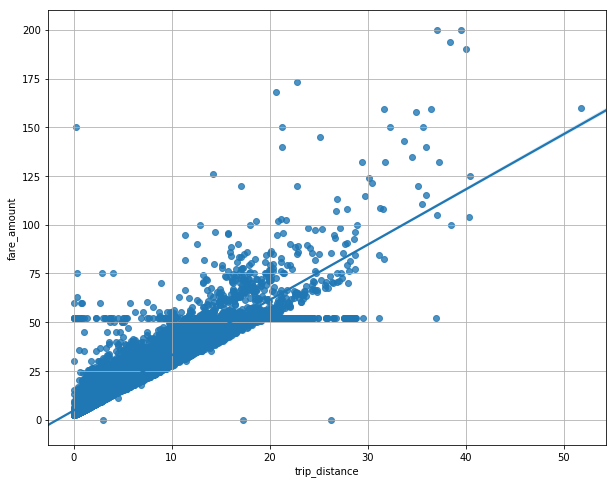

In [12]:
# the line at $52 are JFK <--> Manhattan trips 
sns.regplot('trip_distance', 'fare_amount', yellow.sample(frac=0.01))
plt.gca().grid()

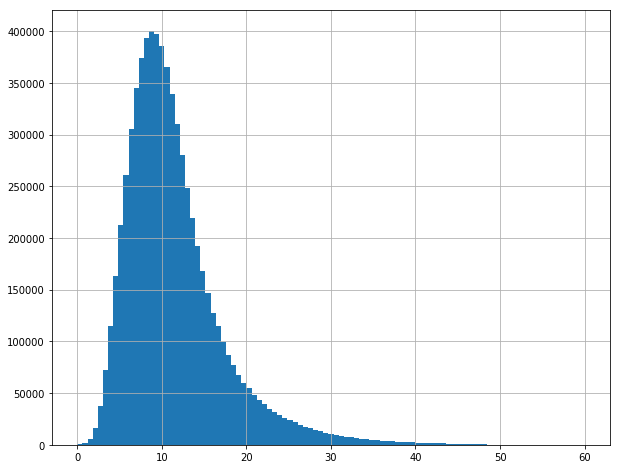

In [14]:
# driving speed distribution
plt.hist(60 * yellow.trip_distance / yellow.trip_duration, bins=np.linspace(0, 60, 100))
plt.gca().grid()

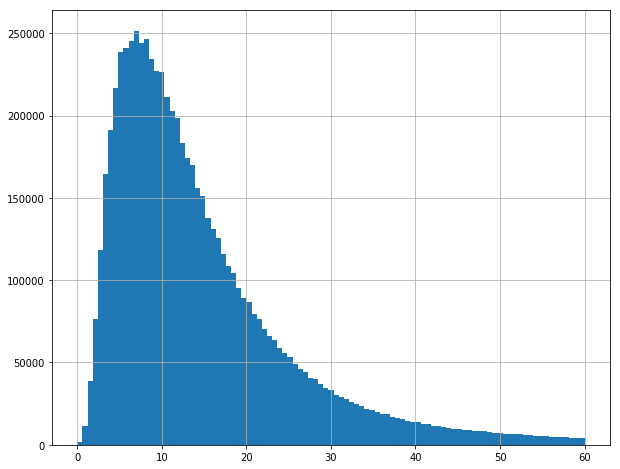

In [15]:
yellow.trip_duration.hist(bins=np.linspace(0, 60, 100))

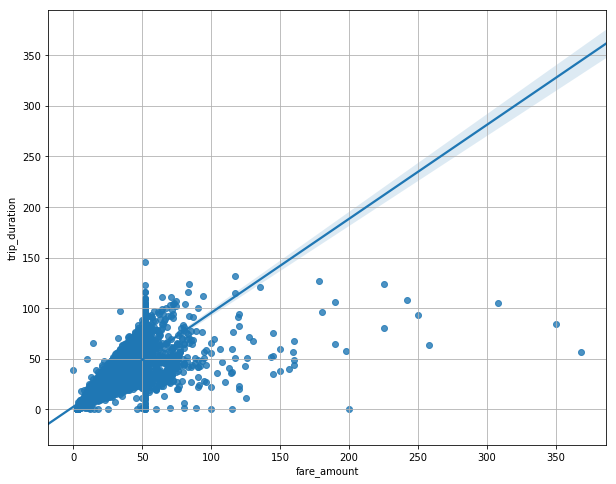

In [16]:
# This is a particularly important plot, as I wasn't sure at first whether to normalize
# by time or amount; normalizing by amount might have advantages since tip culture dictates
# tips are proportional to amount. This plot shows a linear-ish relationship between the
# two, suggesting it probably doesn't matter _too_ much. I do think time is more relevant 
# to the driver, so I will stick with that normalization.
sns.regplot('fare_amount', 'trip_duration', yellow.sample(frac=0.01))
plt.gca().grid()

332262

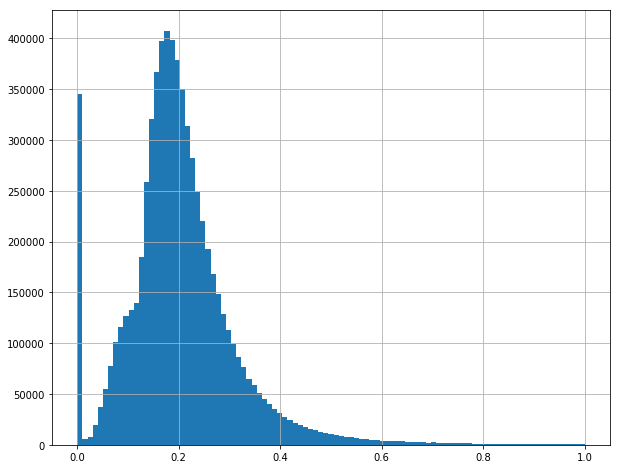

In [17]:
#
#  3. I normalize tip data.
#
#     Tips are given in absolute value per trip; however, what matters to a driver is
#     the average tip per unit time driven. Technically, we would want to optimize the
#     total tips received in a standard 8-hour shift. Analysis of this quantity might
#     benefit from looking at the data beyond the single-trip level. For instance, if
#     a given region is known to give higher tips, but commuters from this region tend
#     to travel to less-populated regions, taking this trip might actually reduce the
#     the total tips for the shift, since the driver is unable to receive tips while
#     waiting for the next passenger. We ignore such effects, and consider only tips
#     per unit time at the single trip level.
#
#     I perform two normalizations here. But I think the time normalization gives a
#     cleaner signal, and is more relevant to the given problem.
#

yellow['normalized_tip_time'] = yellow.tip_amount / yellow.trip_duration
yellow['normalized_tip_amount'] = yellow.tip_amount / yellow.fare_amount
yellow.normalized_tip_time.hist(bins=np.linspace(0, 1, 100))
len(yellow[yellow.normalized_tip_time==0]) # lots of non tippers!

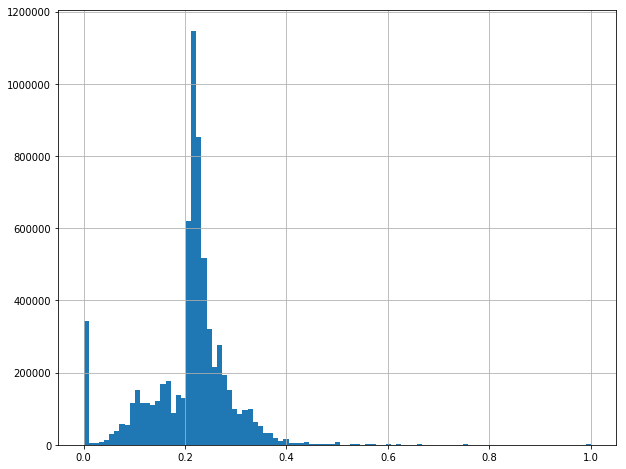

In [18]:
# fare normalization has a bit rattier distribution
yellow.normalized_tip_amount.hist(bins=np.linspace(0, 1, 100))

/home/privitera/education/env3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


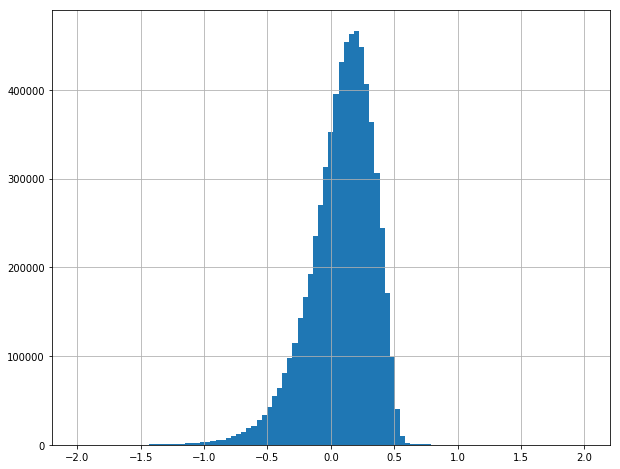

In [19]:
# compare the two normalizations
# it looks like the two normalizations are broadly consistent, although
# normalizing by amount makes tips look "bigger"
(np.log(yellow.normalized_tip_amount) - np.log(yellow.normalized_tip_time)).hist(bins=np.linspace(-2, 2, 100))

In [20]:
yellow.normalized_tip_time.describe(percentiles=[0.25, 0.5, 0.75, 0.9995])

count     6.949538e+06
mean      2.109723e-01
std       4.723463e-01
min       0.000000e+00
25%       1.456311e-01
50%       1.912596e-01
75%       2.485714e-01
99.95%    2.642646e+00
max       3.300000e+02
Name: normalized_tip_time, dtype: float64

In [21]:
yellow[(yellow.RatecodeID == 1)].sort_values('normalized_tip_time', ascending=False).head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_type,ehail_fee,color,trip_duration,normalized_tip_time,normalized_tip_amount
1489620,2,2017-06-29 21:50:13,2017-06-29 21:50:57,1,0.08,1,N,236,236,2.5,...,200.0,0.0,0.3,203.8,NaN,NaN,yellow,0.733333,272.727273,80.0
199951,1,2017-06-10 20:39:45,2017-06-10 20:40:07,1,0.10,1,N,37,37,2.5,...,80.0,0.0,0.3,83.8,NaN,NaN,yellow,0.366667,218.181818,32.0
468950,2,2017-06-15 06:30:14,2017-06-15 06:30:36,1,0.10,1,N,145,145,2.5,...,70.0,0.0,0.3,73.3,1.0,NaN,green,0.366667,190.909091,28.0
1709371,1,2017-06-11 16:59:24,2017-06-11 16:59:43,1,0.10,1,N,31,31,2.5,...,50.0,0.0,0.3,53.3,NaN,NaN,yellow,0.316667,157.894737,20.0
1766369,1,2017-06-30 01:37:01,2017-06-30 01:37:23,1,0.10,1,N,265,265,2.5,...,57.0,0.0,0.3,60.8,NaN,NaN,yellow,0.366667,155.454545,22.8


In [22]:
#
#  4. I drop remaining outliers.
#
#     Events like the above with distance = 0.08 and tip_amount = $200.00 are crazy
#     and don't occur frequently enough to build a model than can confidently predict them.
#     Furthermore, these outliers will adversely affect (in a least-squared regression
#     setting at least) a model's ability to accurately predict in the bulk, where we
#     actually have signal. Here we are not interested in outlier detection, but in
#     understanding population trends, and I think we can safely ignore these points.
#
yellow = yellow[yellow.normalized_tip_time < 3] # 99.95th percentile
print(len(yellow))

6946446


In [23]:
#
#  Save processed data.
#
yellow.to_csv(
    data_location.replace('green_', '').replace('.csv', '_PROCESSED.csv'), 
    index=False)